# Non-negative CP decomposition in Tensorly >=0.6

Since version 0.6 in Tensorly, several options are available to compute non-negative CP, in particular several algorithms:
- Multiplicative updates (MU) (already in Tensorly <0.6)
- Nonnegative Alternating Least Squares using Hierarchical Alternating Least Squares (HALS) 

Non-negativity is an important constraint to handle for tensor decompositions. One could expect that factors must have only non-negative values after it is obtained from a non-negative tensor. 

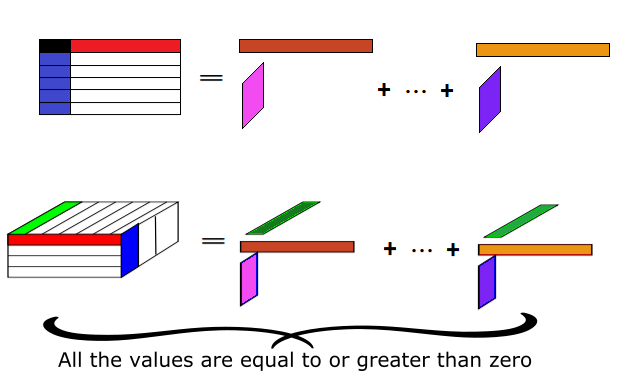

Both algorithms solve the minimization problem by updating each factor alternatively. During a single factor update, other factors are fixed without any change. Then, this update is repeated for each factor. MU updates the whole factor at once with a element-wise multiplication. On the other hand, HALS algorithm aims at columnwise optimal closed-form update. In the figure below, M represents a tensor or matrix which can be decomposed into factors W and H. Two different equations are demonstrated in order to make explicit difference between MU and HALS. In these quations, `k` is the iteration and `p` is the updated column.

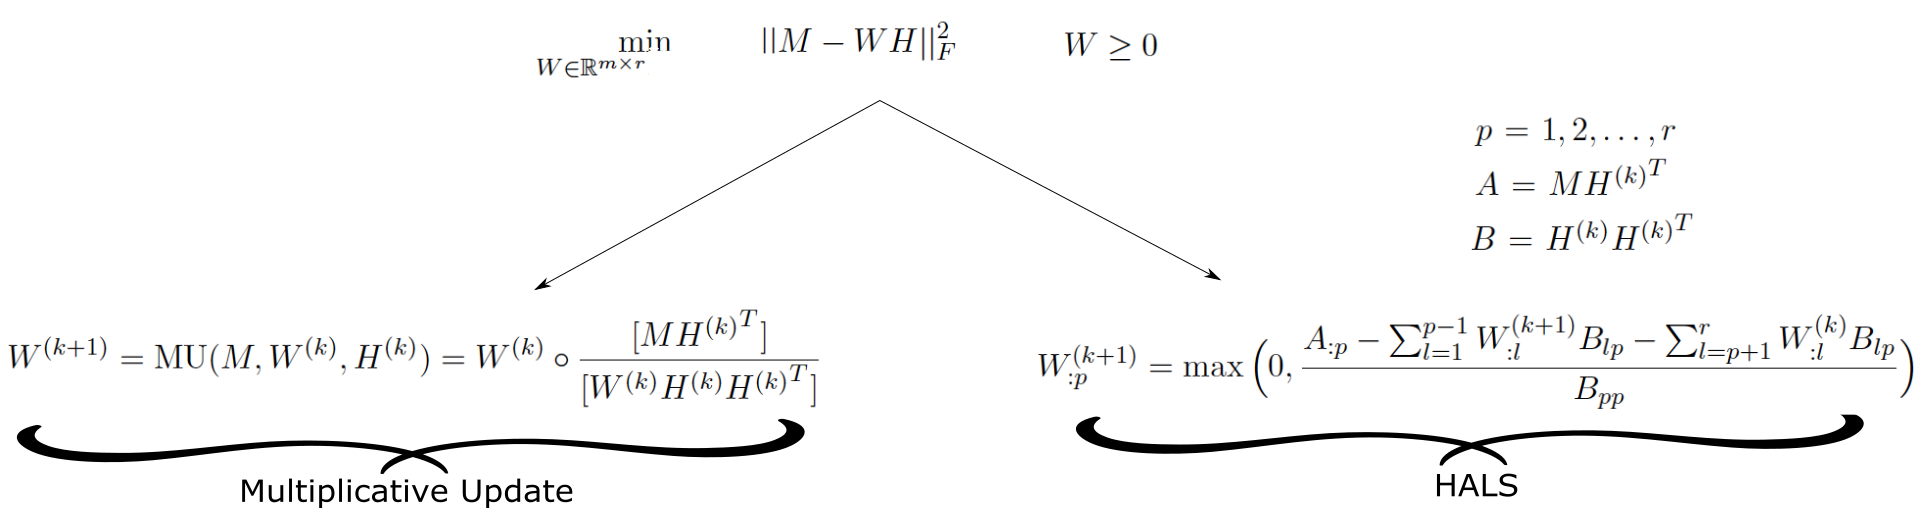

We start by importing a few toolboxes as well as the required functions from tensorly and some libraries such as numpy and time. Note that tensorly uses numpy backend as default, however other backends (pytorch, tensorflow, mxnet and jax) can be used for Non-negative CP (NCP)  decomposition as well.

In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac, non_negative_parafac_hals
from tensorly.decomposition._cp import initialize_cp
from tensorly.cp_tensor import CPTensor
import time

There are several ways to create a tensor with nonnegative entries in tensorly. Here we chose to generate a random from the sequence of integers from 1 to 24000.

In [2]:
#tensor generation
tensor = tl.tensor(np.arange(24000).reshape((30, 40, 20)), dtype=tl.float32)

Our goal here is to produce an approximation of the tensor generated above which follows a low-rank CP model, with non-negative coefficients.

Before using these algorithms, we can use Tensorly to produce a good initial guess for our NCP. In fact, in order to compare both algorithmic options in a fair way, it is a good idea to use same initialized factors in decomposition algorithms. 

We make use of the `initialize_cp` function to initialize the factors of the NCP, and transform these factors (and factors weights) into an instance of the CPTensor class:

In [3]:
weightsinit, factorsinit = initialize_cp(tensor, rank=3)

cpinit = CPTensor((weightsinit,factorsinit))

From now on, we can use the same `cpinit` tensor as the initial tensor when we use decomposition functions. 

Now let us first use the algorithm based on Multiplicative Update, which can be called as follows:

In [4]:
tic = time.time()
tensormu, errors_mu = non_negative_parafac(tensor, rank=3, init=cpinit, return_errors=True)
cp_reconstruction_mu = tl.cp_to_tensor(tensormu)
time_mu = time.time()-tic

Here, we also compute the output tensor from the decomposed factors by using the `cp_to_tensor` function. The tensor `cp_reconstruction_mu` is therefore a low-rank nonnegative approximation of the input tensor `tensor`; looking at the first few values of both tensors shows that this is indeed the case but the approximation is quite coarse.

In [5]:
print('reconstructed tensor\n',cp_reconstruction_mu[10:12,10:12,10:12],'\n')
print('input data tensor\n', tensor[10:12,10:12,10:12])

reconstructed tensor
 [[[8293.027 8291.407]
  [8301.314 8299.782]]

 [[9084.734 9083.706]
  [9094.516 9093.471]]] 

input data tensor
 [[[8210. 8211.]
  [8230. 8231.]]

 [[9010. 9011.]
  [9030. 9031.]]]


Our second (new) option to compute NCP is the HALS algorithm, which can be used as follows:

In [6]:
tic = time.time()
tensorhals, errors_hals = non_negative_parafac_hals(tensor, rank=3, init=cpinit, return_errors=True)
cp_reconstruction_hals = tl.cp_to_tensor(tensorhals)
time_hals = time.time()-tic

Again, we can look at the reconstructed tensor entries.

In [7]:
print('reconstructed tensor\n',cp_reconstruction_hals[10:12,10:12,10:12],'\n')
print('input data tensor\n', tensor[10:12,10:12,10:12])

reconstructed tensor
 [[[8206.2295 8207.044 ]
  [8227.052  8227.8545]]

 [[9006.577  9007.408 ]
  [9027.318  9028.139 ]]] 

input data tensor
 [[[8210. 8211.]
  [8230. 8231.]]

 [[9010. 9011.]
  [9030. 9031.]]]


From only looking at a few entries of the reconstructed tensors, we can already see a huge gap between HALS and MU outputs.

Additionally, HALS algorithm has an option for exact solution to the nonnegative least squares subproblem rather than the faster, approximate solution. Note that the overall HALS algorithm will still provide an approximation of the input data, but will need longer to reach convergence. Exact subroutine solution option can be used simply choosing exact as True in the function:

In [8]:
tic = time.time()
tensorhals_exact, errors_exact = non_negative_parafac_hals(tensor, rank=3, init=cpinit, return_errors=True, exact=True)
cp_reconstruction_exact_hals = tl.cp_to_tensor(tensorhals_exact)
time_exact_hals = time.time()-tic

First comparison option is processing time for each algorithm:

In [9]:
print(str("{:.2f}".format(time_mu)) +' '+ 'seconds')
print(str("{:.2f}".format(time_hals)) +' '+ 'seconds')
print(str("{:.2f}".format(time_exact_hals)) +' '+ 'seconds')

0.04 seconds
0.16 seconds
321.60 seconds


As it is expected, the exact solution takes much longer than the approximate solution, while the gain in performance is often void. Therefore we recommand to avoid this option unless it is specifically required by the application. Also note that on appearance, both MU and HALS have similar runtimes. However, a closer look suggest they are indeed behaving quite differently. Computing the error between the output and the input tensor tells that story better. In Tensorly, we provide a function to calculate Root Mean Square Error (RMSE):

In [10]:
from tensorly.metrics.regression import RMSE

In [11]:
print(RMSE(tensor,cp_reconstruction_mu))
print(RMSE(tensor,cp_reconstruction_hals))
print(RMSE(tensor,cp_reconstruction_exact_hals))

112.268906
51.468357
31.957176


According to the RMSE results, HALS is better than the multiplicative update with both exact and approximate solution. In particular, HALS converged to a much lower reconstruction error than MU. We can better appreciate the difference in convergence speed on the following error per iteration plot:

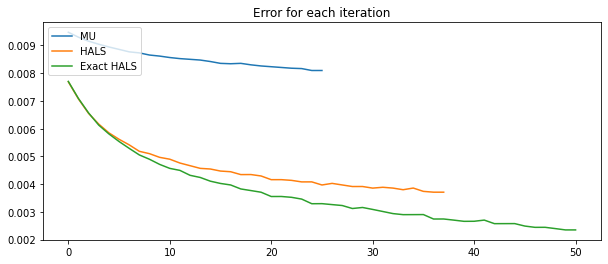

In [12]:
import matplotlib.pyplot as plt
def each_iteration(a,b,c,title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.title(str(title))
    plt.legend(['MU','HALS','Exact HALS'], loc='upper left')
each_iteration(errors_mu, errors_hals, errors_exact, 'Error for each iteration')

In conclusion, on this quick test, it appears that the HALS algorithm gives much better results than the MU original tensorly methods. Our recommendation is to use HALS as a default, and only resort to MU in specific cases (only encountered by expert users most likely).

# Reference

1- Gillis, N., & Glineur, F. (2012). Accelerated multiplicative updates and hierarchical ALS algorithms for nonnegative matrix factorization. Neural computation, 24(4), 1085-1105.  [Link](https://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00256)